In [1]:
# This part adds the path c:\slipskip (or other directory where the repo is located) to the sys.path. 
# This is done so that blocks below can find the modules in other folders (eg. predictor.get_obs_from_api)
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import pandas as pd
import numpy as np

def rename_cols(df):
    df = df.rename(columns={"Precipitation amount": "rainfall_mm", "Snow depth": "snow_depth_cm", "Air temperature": "air_temp", 
     "Maximum temperature": "max_temp", "Minimum temperature": "min_temp", "Ground minimum temperature": "min_ground_temp"})
    cols = ['city','rainfall_mm', 'snow_depth_cm', 'air_temp', 'max_temp', 'min_temp', 'min_ground_temp']
    df = df[cols]

    return df

def merge_and_replace(df, dfh):
    # This functions makes a union of the daily and hourly observations and replaces some values
    merged = pd.concat([df, dfh])
    merged2 = merged.mask(merged == "-", np.nan)
    merged2[["rainfall_mm", "snow_depth_cm", "air_temp", "max_temp", "min_temp", "min_ground_temp"]] = merged2[["rainfall_mm", "snow_depth_cm", "air_temp", "max_temp", "min_temp", "min_ground_temp"]].astype('float64')
    merged2 = merged2[["city","rainfall_mm", "snow_depth_cm", "air_temp", "max_temp", "min_temp", "min_ground_temp"]].interpolate(axis=0)
    merge3 = merged2
    merge3["rainfall_mm"] = merge3["rainfall_mm"].where(merge3["rainfall_mm"] >= 0, 0)
    merge3["snow_depth_cm"] = merge3["snow_depth_cm"].mask(merge3["snow_depth_cm"] == -1, 0)
    return merge3



In [3]:
# import sys, os
# import pandas as pd
# import numpy as np
import datetime as dt
from fmiopendata.wfs import download_stored_query
from fmiopendata.utils import read_url
#import xml.etree.ElementTree as ET
from lxml import etree

def enablePrint():
    sys.stdout = sys.__stdout__

def get_places():

    xml = read_url("http://opendata.fmi.fi/wfs?service=WFS&version=2.0.0&request=getFeature&storedquery_id=fmi::ef::stations")
    #stree = etree.parse(xml)
    #root = ET.fromstring(xml)
    root = etree.fromstring(xml)
    locations = dict()
    for name in root.findall('.//{http://www.opengis.net/gml/3.2}name'):
        if name.attrib['codeSpace'] == 'http://xml.fmi.fi/namespace/locationcode/name':
            city = name.text.split(' ', 1)[0]
            id = name.getparent().find('.//{http://www.opengis.net/gml/3.2}identifier').text
            try:
                place = name.text.split(' ', 1)[1]
            except:
                place = ''
            if city in locations:
                locations[city].append((place,id))
            else:
                locations[city] = [(place, id)]

    #res = np.empty([1, 2])

    #for c in cities:
    #    x = np.array(locations[c]).reshape(len(locations[c]),1)
    #    y = np.broadcast_to([c], (len(locations[c]),1))
    #    r = np.hstack((x,y))
    #    res = np.vstack((res,r))

    return locations #res[1:,:]

    

def get_daily_obs(cities, places):

    # Retrieve the last 10 days daily observations + todays latest 10h observation
    end_time = dt.datetime.utcnow() - dt.timedelta(days=1)
    start_time = end_time - dt.timedelta(days=10)
    # Convert times to properly formatted strings
    start_time = start_time.isoformat(timespec="seconds") + "Z"
    end_time = end_time.isoformat(timespec="seconds") + "Z"

    df = pd.DataFrame({'city': [],'Precipitation amount' : [], 'Air temperature' : [], 'Snow depth' : [], 'Minimum temperature' : [], 'Maximum temperature' : [], 'Ground minimum temperature' : [],})

    for c in cities:
        plcs = places[c]
        appended_data = []
        for p in plcs:
        # For last 10d we get daily values
            obs = download_stored_query("fmi::observations::weather::daily::multipointcoverage",
                                args=["fmisid=" + p[1],
                                    "starttime=" + start_time,
                                    "endtime=" + end_time])
            df2 = pd.DataFrame.from_dict({(i): obs.data[i][j]
                                for i in obs.data.keys() 
                                for j in obs.data[i].keys()},
                            orient='index')
            df2 = df2.applymap(lambda x: x.get('value'))
            if df2.empty == False and (df2['Air temperature'].isnull().all() == False or df2['Ground minimum temperature'].isnull().all() == False):
                appended_data.append(df2)
        df2 = pd.concat(appended_data)
        df2['city'] = c
        df2.index = df2.index.date
        #df2 = df2.groupby([df2.index]).mean()
        df = pd.concat([df,df2])
    
    df = df.groupby([df.index, "city"]).mean().reset_index(level=1)

    return df

def get_hourly_obs(cities, places, cols):
    # Retrieve the last 10 days daily observations + todays latest 10h observation
    end_time = dt.datetime.utcnow()
    start_time = end_time - dt.timedelta(hours=10)
    # Convert times to properly formatted strings
    start_time = start_time.isoformat(timespec="seconds") + "Z"
    end_time = end_time.isoformat(timespec="seconds") + "Z"

    dfh = pd.DataFrame({'city': [], 'Air temperature' : [], 'Precipitation amount' : [],'Snow depth' : []})

    for c in cities:
        plcs = places[c]
        appended_data = []
        for p in plcs:
        # For last 10h we get all observations and use these to calculate the "daily" observations for today
            obs = download_stored_query("fmi::observations::weather::multipointcoverage",
                                args=["fmisid=" + p[1],
                                    "starttime=" + start_time,
                                    "endtime=" + end_time])
            dfh2 = pd.DataFrame.from_dict({(i): obs.data[i][j]
                                for i in obs.data.keys() 
                                for j in obs.data[i].keys()},
                            orient='index')
            dfh2 = dfh2.applymap(lambda x: x.get('value'))
            # We have to calculate some new columns for these hourly observations
            if dfh2.empty == False:
                dfh2['Minimum temperature'] = dfh2['Air temperature'].min()
                dfh2['Maximum temperature'] = dfh2['Air temperature'].max()
                dfh2['Air temperature'] = dfh2['Air temperature'].mean()
                dfh2['Ground minimum temperature'] = dfh2['Minimum temperature']
                dfh2['Precipitation amount'] = dfh2['Precipitation amount'].sum()
            # Let's take only last calculated value as daily value for station
            dfh2 = dfh2.sort_index(axis=0, ascending=False).head(1)
            if dfh2.empty == False and dfh2['Air temperature'].isnull().all() == False:
                appended_data.append(dfh2)
        dfh2 = pd.concat(appended_data)
        dfh2['city'] = c
        dfh2.index = dfh2.index.date
        dfh2 = dfh2[cols]
        dfh = pd.concat([dfh,dfh2])
    
    # Let's take average of station for that city
    dfh = dfh.groupby([dfh.index, "city"]).mean().reset_index(level=1)
    
    return dfh



In [ ]:
# cities = ['Helsinki', 'Kuopio', 'Jyväskylä', 'Lahti', 'Oulu']

# places = get_places()
# df = get_daily_obs(cities, places)
# # dfh = get_hourly_obs(cities, places, df.columns)

# print(df)

In [4]:
# This part executes all the data loading from APIs (get_obs_from_api.py) and does the preprocessing for data (weather_data_trimming.py).
# It takes in a list of cities and starts by searching all the observation stations in theses cities. 
# It then downloads the observations from these stations and basically takes an average over all the stations in one city.
# OBS! When excuting it prints quite a lot of "No observations found" because some of these stations are inactive. Don't worry about that.
import importlib
# import numpy as np
# import data.weather_data.weather_data_trimming as f
# import predictor.get_obs_from_api as g
# importlib.reload(f)
# importlib.reload(g)

cities = ['Helsinki', 'Kuopio', 'Jyväskylä', 'Lahti', 'Oulu']

places = get_places()
df = get_daily_obs(cities, places)
dfh = get_hourly_obs(cities, places, df.columns)

df2 = rename_cols(df)
dfh2 = rename_cols(dfh)
df2 = merge_and_replace(df2, dfh2)


No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found


c:\Users\eliel\anaconda3\envs\my_env\lib\site-packages\fmiopendata\utils.py:43: UserWarning: 

FMI servers responded with the following errors:

 - Unknown 'fmisid' value!
 - URI: /wfs?endtime=2022-10-24T07%3A01%3A52Z&fmisid=104092&request=getFeature&service=WFS&starttime=2022-10-14T07%3A01%3A52Z&storedquery_id=fmi%3A%3Aobservations%3A%3Aweather%3A%3Adaily%3A%3Amultipointcoverage&version=2.0.0

  warnings.warn(exception_text)


No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found
No observations found


c:\Users\eliel\anaconda3\envs\my_env\lib\site-packages\fmiopendata\utils.py:43: UserWarning: 

FMI servers responded with the following errors:

 - Unknown 'fmisid' value!
 - URI: /wfs?endtime=2022-10-25T07%3A02%3A07Z&fmisid=104092&request=getFeature&service=WFS&starttime=2022-10-24T21%3A02%3A07Z&storedquery_id=fmi%3A%3Aobservations%3A%3Aweather%3A%3Amultipointcoverage&version=2.0.0

  warnings.warn(exception_text)


No observations found
No observations found
No observations found
No observations found
No observations found
No observations found


In [5]:
# import pandas as pd
# import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

def get_features(df, cities):

    appended_data = []
    for c in cities:
        dff = df.loc[df['city'] == c]
        dff["rain_sum_7d"] = dff["rainfall_mm"].replace(-1, 0).shift(1).rolling(7).sum().round(2)
        dff["snow_depth_cm"] = dff["snow_depth_cm"].replace(0, np.nan).ffill()
        dff["snow_var_7d"] = dff["snow_depth_cm"].replace(-1, 0).shift(1).rolling(7).var().round(2)
        dff["min_temp_2d"] = dff["min_temp"].shift(1).rolling(2).min().round(2)
        dff["max_temp_2d"] = dff["max_temp"].shift(1).rolling(2).max().round(2)
        dff["is_neg"] = dff["min_temp"]<0
        dff["is_neg"] = dff["is_neg"].astype(int).shift(1)
        dff["neg_rate_7d"] = dff["is_neg"].shift(1).rolling(7).mean().round(2)
        dff = dff.bfill()
        features = dff.drop(columns=['rainfall_mm', 'snow_depth_cm', 'air_temp', 'max_temp', 'min_temp', 'min_ground_temp', 'is_neg']).sort_index(axis=0, ascending=False)
        features = features.head(1).fillna(0)
        appended_data.append(features)
    
    all_features = pd.concat(appended_data)

    return all_features

In [6]:
# This part extracts features from the observation data. It returns a numpy array.
# import model.weather_feature_extraction as m
import datetime as dt
# importlib.reload(m)

df3 = get_features(df2, cities)
X_pred = df3.to_numpy()
date = df3.head(1).index.item() + dt.timedelta(days=1)

print(X_pred)

[['Helsinki' 2.3 0.0 -0.62 9.58 0.0]
 ['Kuopio' 2.6 0.0 -0.97 7.23 0.14]
 ['Jyväskylä' 3.7 0.0 -4.5 6.15 0.43]
 ['Lahti' 3.0 0.0 -3.1 7.0 0.29]
 ['Oulu' 0.3 0.0 -1.97 6.07 0.14]]


In [7]:
# This part downloads the trained model and does the prediction for each city. 
# The output is a numpy array with Date, City, Binary prediction, Prediction as probability
import joblib

model = joblib.load('../model/random_forest_model')
# model = joblib.load('./model/random_forest_model')

predictions = []
for i, city in enumerate(cities):
    single_pred = []
    single_pred.append(date.strftime("%m/%d/%Y"))
    single_pred.append(city)
    y_pred = model.predict(X_pred[i,1:].reshape(1,5))
    y_prob = model.predict_proba(X_pred[i,1:].reshape(1,5))
    single_pred.append(y_pred[0])
    single_pred.append(y_prob[0][1])
    predictions.append(single_pred)

predictions = np.array(predictions)

print(predictions)

[['10/26/2022' 'Helsinki' '0.0' '0.02']
 ['10/26/2022' 'Kuopio' '0.0' '0.0']
 ['10/26/2022' 'Jyväskylä' '0.0' '0.02']
 ['10/26/2022' 'Lahti' '0.0' '0.05']
 ['10/26/2022' 'Oulu' '0.0' '0.08']]


In [35]:
import geopandas as gpd

# Reading shapefile of map of Finland and creating df for coordinates of cities.
# shapefile = 'slipskip/finland_shapefile/fi_1km.shp'
shapefile = '../finland_shapefile/fi_1km.shp'

finMap = gpd.read_file(shapefile)
data = {'City': ['Helsinki', 'Kuopio', 'Jyväskylä', 'Lahti', 'Oulu'],
           'Latitude': [60.17332, 62.897968, 62.242603, 60.980381, 65.012093],
           'Longitude': [24.94102, 27.678171, 25.747257, 25.654988, 25.465076]}

longLat = pd.DataFrame(data)

In [36]:
from shapely.geometry import Point, Polygon

# Creating map of Finland
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(longLat['Longitude'], longLat['Latitude'])]
geo_df = gpd.GeoDataFrame(longLat, 
                          crs = crs, 
                          geometry = geometry)


pred = pd.DataFrame(predictions)
# print(pred[2])

# Putting slip warning to the cities not covered yet
geo_df['value'] = pred[2].apply(pd.to_numeric).astype(int)

# Putting predicted value to Helsinki.
# geo_df.loc[0,'value'] = y_pred
print(geo_df)

        City   Latitude  Longitude                   geometry  value
0   Helsinki  60.173320  24.941020  POINT (24.94102 60.17332)      0
1     Kuopio  62.897968  27.678171  POINT (27.67817 62.89797)      0
2  Jyväskylä  62.242603  25.747257  POINT (25.74726 62.24260)      0
3      Lahti  60.980381  25.654988  POINT (25.65499 60.98038)      0
4       Oulu  65.012093  25.465076  POINT (25.46508 65.01209)      0


c:\Users\eliel\anaconda3\envs\my_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [37]:
# Creating color column
geo_df['color'] = geo_df['value'].mask(geo_df['value'] == 1, 'orange')
geo_df['color'] = geo_df['color'].mask(geo_df['color'] == 0, 'green')
print(geo_df['color'])

0    green
1    green
2    green
3    green
4    green
Name: color, dtype: object


Text(0.5, 1.0, 'Slip warnings in Finland')

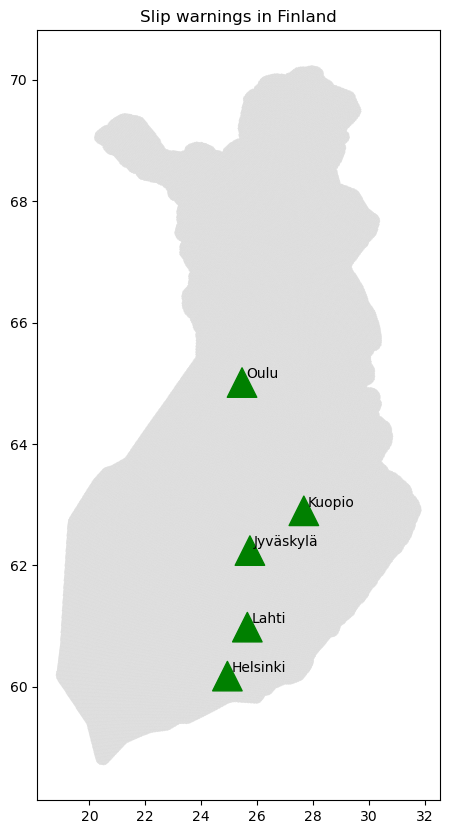

In [39]:
from sre_constants import GROUPREF_UNI_IGNORE
import matplotlib.pyplot as plt

# print(geo_df)

# Create map, green if no warning, orange if warning
fig, ax = plt.subplots(figsize = (10,10))
finMap.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax,c=geo_df['color'], marker='^', markersize=450)
# ax.annotate('Helsinki', xy=(24.94102, 60.17332), xytext=(3, 3), textcoords="offset points")
for x, y, label in zip(geo_df["Longitude"], geo_df["Latitude"], geo_df["City"]):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.set_title('Slip warnings in Finland')